# Runtime Regression

## Preliminaries and Utils

In [1]:
# !pip install seaborn
# !pip install sortedcontainers
# !pip install matplotlib
# !pip install scipy
# !pip install pandas
# !pip install scikit-learn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import warnings

from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report, f1_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

from modules.prediction_models import NAGPolynomialRegressor
from modules.prediction_models import RidgePolynomialRegressor

from modules.utils import PrintSummary, ShowPlots

In [3]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [4]:
summary = PrintSummary()
plots = ShowPlots()

In [5]:
def convert_to_hms(time_value, unit="seconds"):
    if unit == "minutes":
        time_value *= 60  # Convert minutes to seconds
    hours, remainder = divmod(time_value, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

## Data Loading

In [6]:
data_train = 'mx100/job_data_train.parquet'

In [7]:
data_test = 'mx100/job_data_test.parquet'

In [8]:
df_train = pd.read_parquet(data_train, engine="pyarrow").copy()
df_test = pd.read_parquet(data_test, engine="pyarrow").copy()

In [9]:
df_train

,Job Number,User ID,Requested Number of Nodes,Requested Number of CPU,Requested Number of GPU,Total Requested Memory,Desired QoS,Requested Time,Run Time,Duration (H4),...,Avg Running Requested Nodes,Jobs Currently Running,Longest Current Running Time,Sum Current Running Times,Occupied Resources,Break Time,Time of Day Cos,Time of Day Sin,Time of Week Cos,Time of Week Sin
7643,2686552,1470,32,4096,128,29440.0000,4,86400,77702,Long,...,32.0,0,77702,77702,32,0.0,1.000000,0.000000,1.000000,0.000000
8413,5370710,1540,1,4,4,0.2500,1,86400,13243,Long,...,0.0,0,0,0,0,0.0,0.263943,0.964538,0.982707,0.185166
8233,175694,906,8,1024,32,1840.0000,1,36000,19576,Long,...,0.0,0,0,0,0,0.0,0.234011,0.972234,0.981880,0.189503
8272,2214444,303,13,832,52,2537.4375,1,86400,17052,Long,...,0.0,0,0,0,0,0.0,0.164474,0.986381,0.979908,0.199449
7979,2687047,906,16,2048,64,7360.0000,1,36000,19869,Long,...,8.0,0,19576,19576,8,3395.0,-0.010690,0.999943,0.974587,0.224010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177274,4698474,1711,1,64,4,7.3750,1,14400,4534,Medium,...,0.0,0,0,0,0,0.0,0.727972,-0.685607,0.994182,-0.107710
176541,3560248,1711,1,64,4,7.3750,1,14400,4504,Medium,...,0.0,0,0,0,0,0.0,0.727972,-0.685607,0.994182,-0.107710
176440,4754973,1711,1,64,4,7.3750,1,14400,4171,Medium,...,0.0,0,0,0,0,0.0,0.727972,-0.685607,0.994182,-0.107710
176822,779011,1711,1,64,4,7.3750,1,14400,4334,Medium,...,0.0,0,0,0,0,0.0,0.727972,-0.685607,0.994182,-0.107710


In [10]:
useful_columns = ["Job Number", "User ID", "Requested Number of Nodes", "Requested Number of CPU", "Requested Number of GPU", "Total Requested Memory", "Desired QoS", "Requested Time", "Run Time", "Duration (H7)", "Duration (H4)"]

In [11]:
# Keep only the necessary columns
df_train = df_train[useful_columns]
df_test = df_test[useful_columns]

## Data Inspection

In [12]:
df_train.describe()

,Job Number,User ID,Requested Number of Nodes,Requested Number of CPU,Requested Number of GPU,Total Requested Memory,Requested Time,Run Time
count,1.557640e+05,155764.000000,155764.000000,155764.000000,155764.000000,1.557640e+05,155764.000000,155764.000000
mean,3.122174e+06,790.980535,4.443646,353.472709,14.811863,4.047878e+03,35473.476927,5398.248665
std,1.799560e+06,573.138093,16.247213,1486.355238,61.282511,6.091485e+04,37275.936550,15656.616993
min,5.000000e+00,3.000000,1.000000,1.000000,0.000000,0.000000e+00,60.000000,1.000000
25%,1.567995e+06,188.000000,1.000000,16.000000,4.000000,9.375000e-01,1800.000000,29.000000
50%,3.120938e+06,666.000000,1.000000,64.000000,4.000000,7.375000e+00,14400.000000,205.000000
75%,4.682118e+06,1240.000000,2.000000,192.000000,4.000000,5.612500e+01,86400.000000,1718.250000
max,6.242680e+06,1743.000000,256.000000,32768.000000,1024.000000,1.968000e+06,86400.000000,86381.000000


In [13]:
df_test.describe()

,Job Number,User ID,Requested Number of Nodes,Requested Number of CPU,Requested Number of GPU,Total Requested Memory,Requested Time,Run Time
count,6.675600e+04,66756.000000,66756.000000,66756.000000,66756.000000,6.675600e+04,66756.000000,66756.000000
mean,3.122346e+06,354.388579,3.400309,343.112904,12.788858,1.787430e+03,60552.618192,4136.398107
std,1.805720e+06,444.051463,10.296113,946.713824,40.725735,2.662671e+04,33949.192091,13177.133188
min,4.600000e+01,3.000000,1.000000,1.000000,0.000000,9.765625e-04,60.000000,1.000000
25%,1.549400e+06,8.000000,1.000000,128.000000,4.000000,2.925000e+01,28800.000000,1.000000
50%,3.122510e+06,141.000000,1.000000,128.000000,4.000000,2.962500e+01,86400.000000,27.000000
75%,4.694877e+06,666.000000,1.000000,128.000000,4.000000,2.962500e+01,86400.000000,1666.000000
max,6.242697e+06,1740.000000,256.000000,32768.000000,1024.000000,1.968000e+06,86400.000000,86395.000000


## Data Preparation

In [14]:
feature_names = ["User ID", "Requested Number of Nodes", "Requested Number of CPU", "Requested Number of GPU", "Total Requested Memory", "Desired QoS", "Requested Time"]

target_name = "Run Time"

In [15]:
X_train = df_train[feature_names]
y_train = df_train[target_name]
X_test = df_test[feature_names]
y_test = df_test[target_name]

## Normalized Poynomial Regressor

In [16]:
predictor = RidgePolynomialRegressor(degree=2, alpha=0.01)
# predictor = NAGPolynomialRegressor(degree=2, alpha=0.01)
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)

### Analysis

In [17]:
print(f"Prediction Range: [{int(y_pred.min())}, {int(y_pred.max())}]")

Prediction Range: [1, 47131]


In [18]:
analysis_pr = df_test[['Job Number', 'Requested Time', 'Run Time']]
analysis_pr['Predicted Runtime'] = y_pred
analysis_pr.columns = ['Job_ID', 'Requested_Runtime', 'Actual_Runtime', 'Predicted_Runtime']

In [19]:
# Whenever the predicted runtime is higher than the requested runtime take the time limit
analysis_pr["Predicted_Runtime"] = analysis_pr[["Predicted_Runtime", "Requested_Runtime"]].min(axis=1)

In [20]:
analysis_pr['Requested_Error'] = analysis_pr['Requested_Runtime'] - analysis_pr['Actual_Runtime']
analysis_pr['Prediction_Error'] = abs(analysis_pr['Predicted_Runtime'] - analysis_pr['Actual_Runtime'])

In [21]:
# 1. Basic Statistical Overview
analysis_pr.describe()

,Job_ID,Requested_Runtime,Actual_Runtime,Predicted_Runtime,Requested_Error,Prediction_Error
count,6.675600e+04,66756.000000,66756.000000,66756.000000,66756.000000,66756.000000
mean,3.122346e+06,60552.618192,4136.398107,8372.449053,56416.220085,9185.782536
std,1.805720e+06,33949.192091,13177.133188,5315.652393,35496.403520,9611.450997
min,4.600000e+01,60.000000,1.000000,1.000000,2.000000,0.000000
25%,1.549400e+06,28800.000000,1.000000,4370.000000,20714.000000,4183.750000
50%,3.122510e+06,86400.000000,27.000000,9805.000000,85213.000000,9803.000000
75%,4.694877e+06,86400.000000,1666.000000,9805.000000,86399.000000,9804.000000
max,6.242697e+06,86400.000000,86395.000000,47131.000000,86399.000000,77978.000000


In [22]:
# 2. Prediction Summary
summary.show_prediction_summary(analysis_pr)

,Prediction_Type,Count,Percentage,Average_Error
0,Exact,19,0.028462,0.000000
1,Overestimate,53571,80.248966,8362.620784
2,Underestimate,13166,19.722572,12548.392906


In [23]:
# 3. Predicted values analysis
(requested_runtime_frequency, actual_runtime_frequency, predicted_runtime_frequency) = summary.show_runtime_frequency(analysis_pr)

Number of unique requested runtimes: 207
Number of unique actual runtimes: 11153
Number of unique predicted runtimes: 1273


In [24]:
requested_runtime_frequency.head(1)

,Requested_Runtime,Frequency
0,86400,34237


In [25]:
actual_runtime_frequency.head(1)

,Actual_Runtime,Frequency
0,1,18530


In [26]:
predicted_runtime_frequency.head(1)

,Predicted_Runtime,Frequency
0,9805,29238


In [27]:
summary.print_metrics(analysis_pr)

Mean Absolute Error (MAE): 9185.782536401222
Root Mean Squared Error (RMSE): 13295.006853158173


In [28]:
avg_user_dt_1 = convert_to_hms(int(analysis_pr['Requested_Error'].mean()))
avg_pred_dt_1 = convert_to_hms(int(analysis_pr['Prediction_Error'].mean()))
avg_rt_dt_1 = convert_to_hms(int(analysis_pr['Actual_Runtime'].mean()))
print(f"Average user-input error (hh:mm:ss)  :  {avg_user_dt_1}")
print(f"Average prediction error (hh:mm:ss)  :  {avg_pred_dt_1}")

Average user-input error (hh:mm:ss)  :  15:40:16
Average prediction error (hh:mm:ss)  :  02:33:05


In [29]:
# 4. Visualization

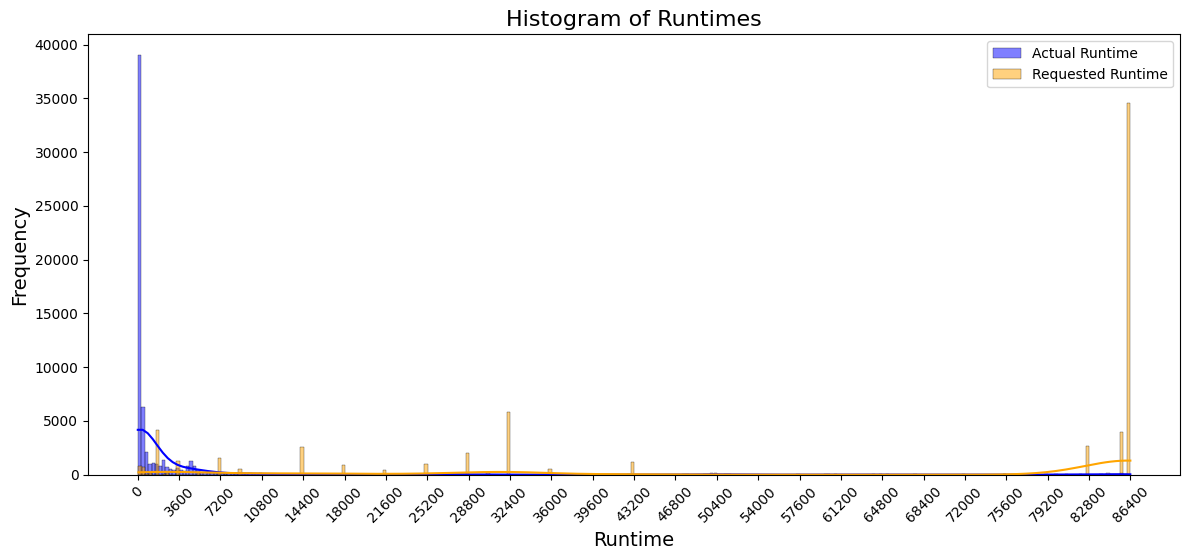

In [30]:
plots.show_runtime_histogram(analysis_pr['Actual_Runtime'], analysis_pr['Requested_Runtime'], "Actual Runtime", "Requested Runtime")

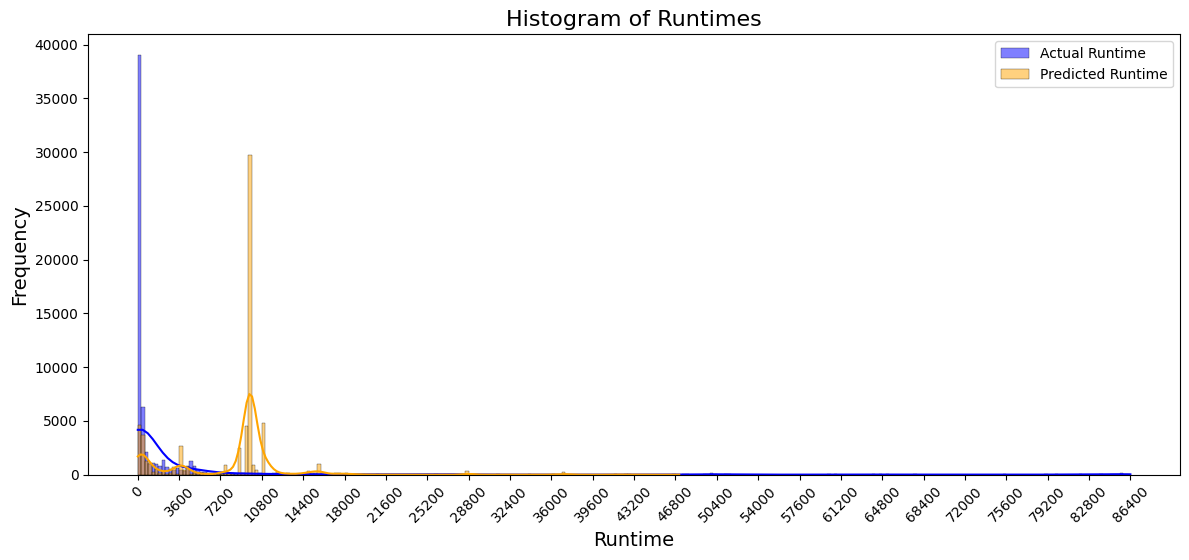

In [31]:
plots.show_runtime_histogram(analysis_pr['Actual_Runtime'], analysis_pr['Predicted_Runtime'], "Actual Runtime", "Predicted Runtime")

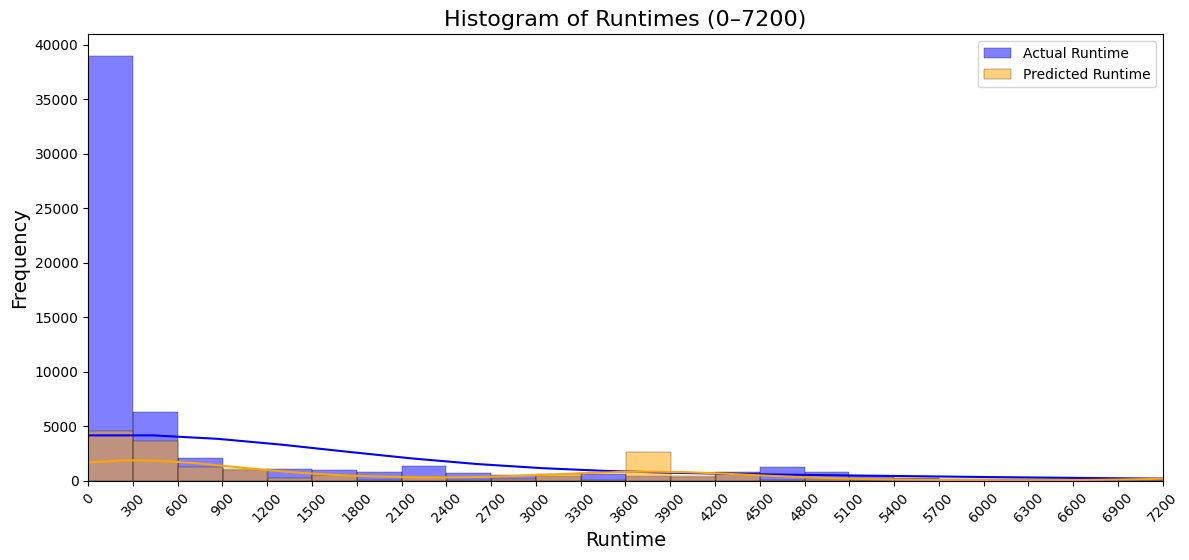

In [32]:
plots.show_runtime_histogram_limited(analysis_pr['Actual_Runtime'], analysis_pr['Predicted_Runtime'], "Actual Runtime", "Predicted Runtime")

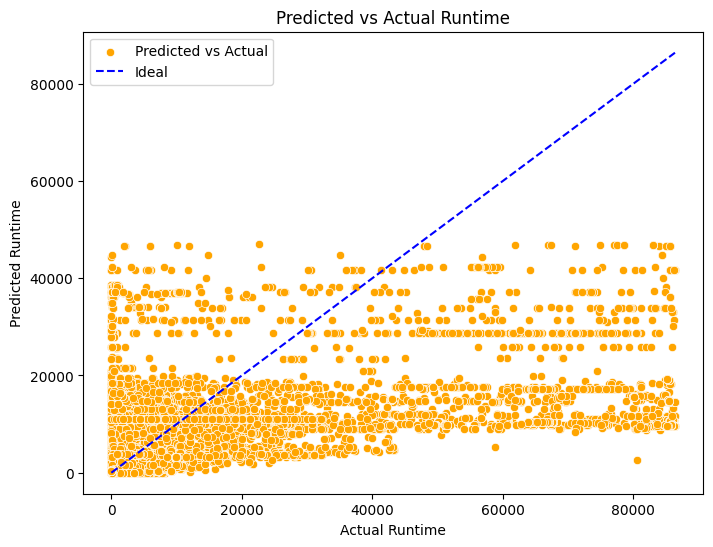

In [33]:
# Scatter plot: Actual vs. Predicted Runtime
plots.show_scatter_plot(analysis_pr)

## Decision Tree Regressor

In [34]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test).astype(int)

### Analysis

In [35]:
print(f"Prediction Range: [{int(y_pred.min())}, {int(y_pred.max())}]")

Prediction Range: [1, 86011]


In [36]:
analysis_dt = df_test[['Job Number', 'Requested Time', 'Run Time']]
analysis_dt['Predicted Runtime'] = y_pred
analysis_dt.columns = ['Job_ID', 'Requested_Runtime', 'Actual_Runtime', 'Predicted_Runtime']

In [37]:
# Whenever the predicted runtime is higher than the requested runtime take the time limit
analysis_dt["Predicted_Runtime"] = analysis_dt[["Predicted_Runtime", "Requested_Runtime"]].min(axis=1)

In [38]:
analysis_dt['Requested_Error'] = analysis_dt['Requested_Runtime'] - analysis_dt['Actual_Runtime']
analysis_dt['Prediction_Error'] = abs(analysis_dt['Predicted_Runtime'] - analysis_dt['Actual_Runtime'])

In [39]:
analysis_dt.describe()

,Job_ID,Requested_Runtime,Actual_Runtime,Predicted_Runtime,Requested_Error,Prediction_Error
count,6.675600e+04,66756.000000,66756.000000,66756.000000,66756.000000,66756.000000
mean,3.122346e+06,60552.618192,4136.398107,19779.714962,56416.220085,19628.583918
std,1.805720e+06,33949.192091,13177.133188,17720.349958,35496.403520,17924.912643
min,4.600000e+01,60.000000,1.000000,1.000000,2.000000,0.000000
25%,1.549400e+06,28800.000000,1.000000,1677.000000,20714.000000,1379.000000
50%,3.122510e+06,86400.000000,27.000000,10545.000000,85213.000000,14752.500000
75%,4.694877e+06,86400.000000,1666.000000,37461.000000,86399.000000,37460.000000
max,6.242697e+06,86400.000000,86395.000000,86011.000000,86399.000000,86373.000000


In [40]:
summary.show_prediction_summary(analysis_dt)

,Prediction_Type,Count,Percentage,Average_Error
0,Exact,124,0.185751,0.000000
1,Overestimate,49947,74.820241,23571.095441
2,Underestimate,16685,24.994008,7972.444951


In [41]:
(requested_runtime_frequency, actual_runtime_frequency, predicted_runtime_frequency) = summary.show_runtime_frequency(analysis_dt)

Number of unique requested runtimes: 207
Number of unique actual runtimes: 11153
Number of unique predicted runtimes: 948


In [42]:
requested_runtime_frequency.head(1)

,Requested_Runtime,Frequency
0,86400,34237


In [43]:
actual_runtime_frequency.head(1)

,Actual_Runtime,Frequency
0,1,18530


In [44]:
predicted_runtime_frequency.head(1)

,Predicted_Runtime,Frequency
0,37461,29238


In [45]:
summary.print_metrics(analysis_dt)

Mean Absolute Error (MAE): 19628.58391755048
Root Mean Squared Error (RMSE): 26581.55350594829


In [46]:
avg_user_dt_2 = convert_to_hms(int(analysis_dt['Requested_Error'].mean()))
avg_pred_dt_2 = convert_to_hms(int(analysis_dt['Prediction_Error'].mean()))
avg_rt_dt_2 = convert_to_hms(int(analysis_dt['Actual_Runtime'].mean()))
print(f"Average user-input error (hh:mm:ss)  :  {avg_user_dt_2}")
print(f"Average prediction error (hh:mm:ss)  :  {avg_pred_dt_2}")

Average user-input error (hh:mm:ss)  :  15:40:16
Average prediction error (hh:mm:ss)  :  05:27:08


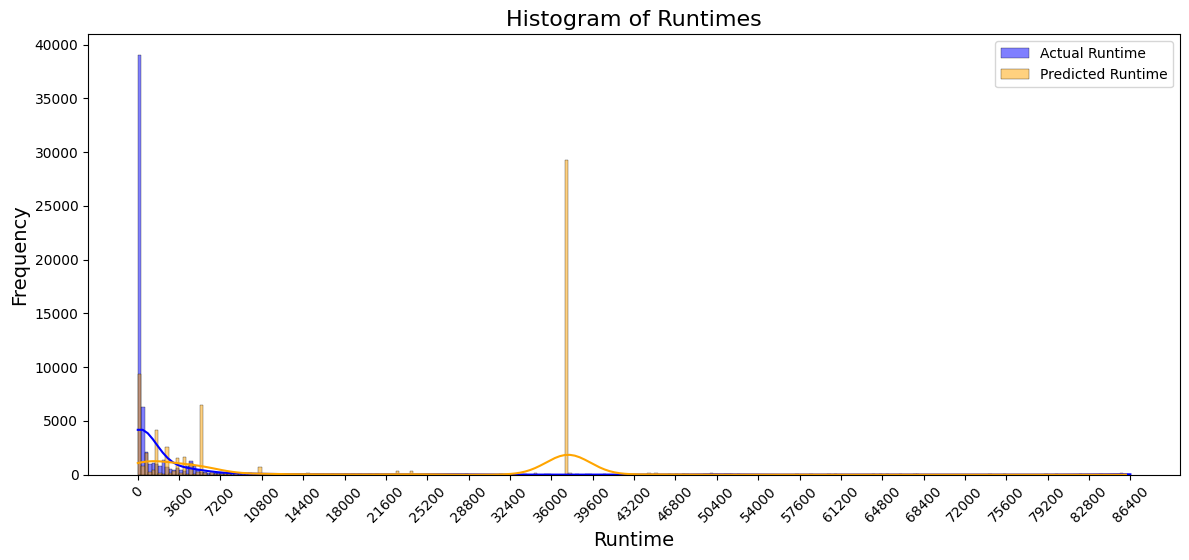

In [47]:
# Histogram of Runtimes
plots.show_runtime_histogram(analysis_dt['Actual_Runtime'], analysis_dt['Predicted_Runtime'], "Actual Runtime", "Predicted Runtime")

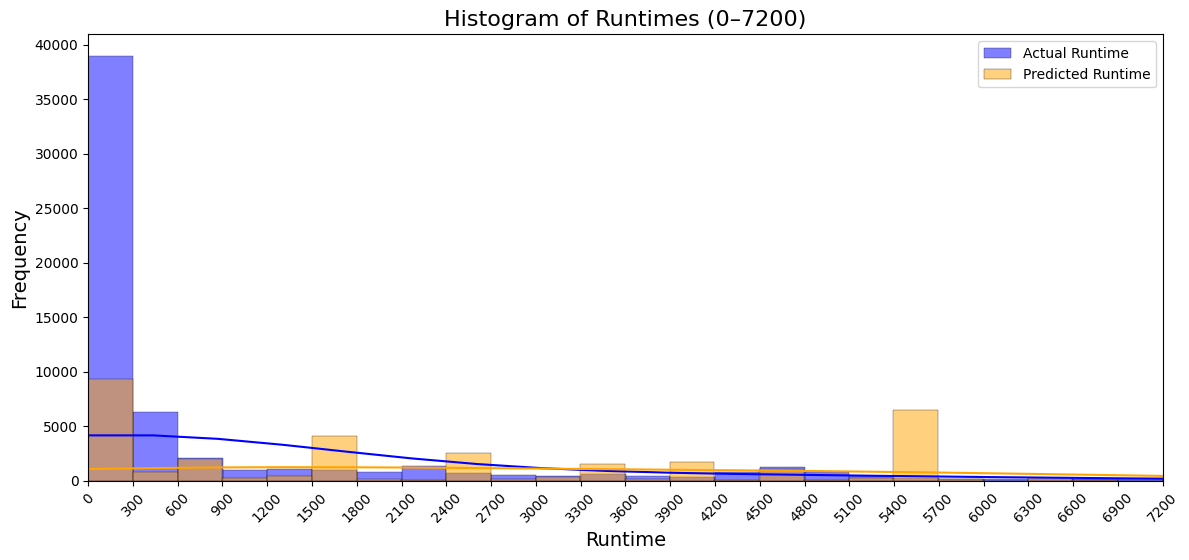

In [48]:
plots.show_runtime_histogram_limited(analysis_dt['Actual_Runtime'], analysis_dt['Predicted_Runtime'], "Actual Runtime", "Predicted Runtime")

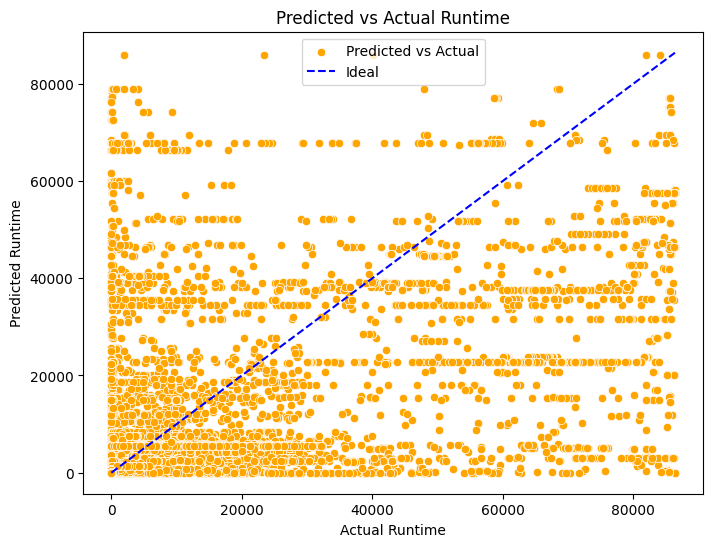

In [49]:
# Scatter plot: Actual vs. Predicted Runtime
plots.show_scatter_plot(analysis_dt)

In [50]:
importances = regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
0,User ID,0.366524
4,Total Requested Memory,0.244557
6,Requested Time,0.244033
2,Requested Number of CPU,0.050854
3,Requested Number of GPU,0.049968
1,Requested Number of Nodes,0.025884
5,Desired QoS,0.018179


## K-NN Classifier - 7 Classes

In [51]:
target_name = "Duration (H7)"
k = 7

In [52]:
X_train = df_train[feature_names]
y_train = df_train[target_name]
X_test = df_test[feature_names]
y_test = df_test[target_name]

In [53]:
# Standardize features (k-NN works better with scaled data)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
# Train k-NN model
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [55]:
# Predictions
y_pred = knn.predict(X_test)

In [56]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.57


In [57]:
# Compute F1-score (macro & weighted for class imbalance)
f1_macro = f1_score(y_test, y_pred, average="macro")  # Gives equal weight to all classes
f1_weighted = f1_score(y_test, y_pred, average="weighted")  # Accounts for class imbalance

print(f"F1 Score (Macro): {f1_macro:.2f}")
print(f"F1 Score (Weighted): {f1_weighted:.2f}")

F1 Score (Macro): 0.34
F1 Score (Weighted): 0.57


In [58]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

        Long       0.11      0.39      0.18      1822
      Medium       0.61      0.18      0.28      8574
 Medium-Long       0.24      0.16      0.19      3357
Medium-Short       0.25      0.16      0.20     13277
       Short       0.23      0.52      0.32      6893
   Very-Long       0.48      0.20      0.28      1982
  Very-Short       0.94      0.94      0.94     30851

    accuracy                           0.57     66756
   macro avg       0.41      0.36      0.34     66756
weighted avg       0.62      0.57      0.57     66756



## K-NN Classifier - 4 Classes

In [59]:
target_name = "Duration (H4)"
k = 4

In [60]:
X_train = df_train[feature_names]
y_train = df_train[target_name]
X_test = df_test[feature_names]
y_test = df_test[target_name]

In [61]:
# Standardize features (k-NN works better with scaled data)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
# Train k-NN model
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [63]:
# Predictions
y_pred = knn.predict(X_test)

In [64]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.69


In [65]:
# Compute F1-score (macro & weighted for class imbalance)
f1_macro = f1_score(y_test, y_pred, average="macro")  # Gives equal weight to all classes
f1_weighted = f1_score(y_test, y_pred, average="weighted")  # Accounts for class imbalance

print(f"F1 Score (Macro): {f1_macro:.2f}")
print(f"F1 Score (Weighted): {f1_weighted:.2f}")

F1 Score (Macro): 0.55
F1 Score (Weighted): 0.69


In [66]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

        Long       0.40      0.34      0.37      6537
      Medium       0.64      0.52      0.57     21223
       Short       0.27      0.43      0.33      8145
  Very-Short       0.94      0.94      0.94     30851

    accuracy                           0.69     66756
   macro avg       0.56      0.56      0.55     66756
weighted avg       0.71      0.69      0.69     66756

